In this notebook, we implement gradient descent from scratch. The idea is to calculate the different steps with pen and paper for comparison, at least the first iteration. This will help understand the algorithm steps in more depth.
Our task is to fit a line through 3 example data points. This regression problem can be thought of as a tiny neural net with just one neuron: an input $x_1$ weighted by $\theta_1$, a bias $\theta_0$ and a predicted output $\hat{y}$.

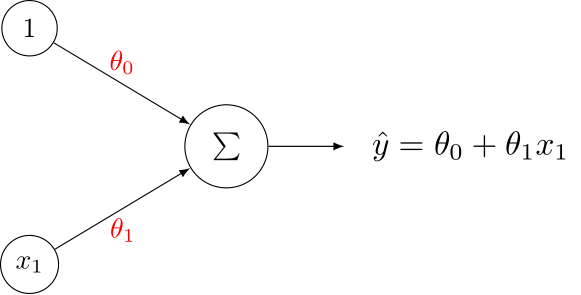

In [2]:
from IPython.display import Image
Image('neuron.png', width=400)

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt

As fictional application, we want to predict median house prices in an area based on median income in this region. We have 3 data points as training data:

In [4]:
# 3 data points to be fitted by a regression line (stored as 2D array for matrix calculations)
x = np.array([[100], [70], [140]]) # income (in 1000)
y = np.array([[300], [200], [500]]) # house price (in 1000)

# we add a constant value 1 for the bias term (to be multiplied with theta0)
x_with_bias = np.concatenate((np.ones((len(x), 1)), x), axis=1)
print('x_with_bias = ', x_with_bias)
print('y = ', y)

x_with_bias =  [[  1. 100.]
 [  1.  70.]
 [  1. 140.]]
y =  [[300]
 [200]
 [500]]


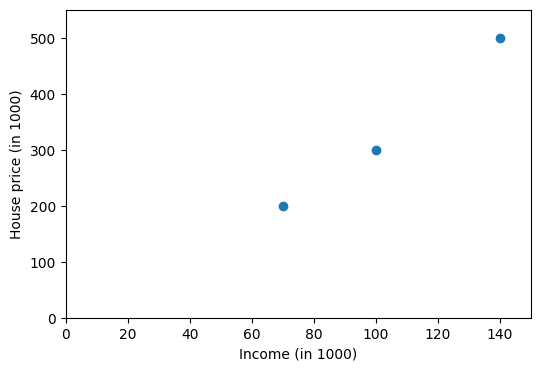

In [5]:
# plot data
def plot_points():
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y)
    plt.axis([0, 150, 0, 550])
    plt.xlabel('Income (in 1000)')
    plt.ylabel('House price (in 1000)')

plot_points()

In [6]:
# init params
theta_init = np.array([[70], [1]]) # manual selection of some start value 
# theta_init = np.random.randn(2, 1) # alternative: random start value (mean 0, standard deviation 1)
print('theta_init = ', theta_init)

alpha = 0.00005 # Learning rate. Note that for higher learning rate, we get exploding gradients, so we should use regularization (omitted here to keep simple).
m = len(y) # number of samples = 3
n_iter = 1000000 # number of iterations
print_every = 50000 # output current values every ... iterations
eps = 0.1 # stop if gradient falls below this threshold


theta_init =  [[70]
 [ 1]]


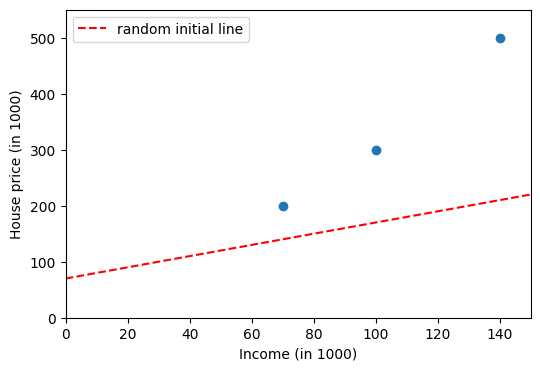

In [7]:
# plot initial line (if not visible, it lies outside the selected plot range)
x_points = np.linspace(0, 150, 500).reshape(-1, 1)

def plot_init_data():
    plot_points()
    plt.plot(x_points, theta_init[0] + theta_init[1] * x_points, color='r', linestyle='--', label='random initial line')
    plt.legend()

plot_init_data()

We see that the loss (error) of the red initial line is quite high as the blue points are not well approximated. To quantify this loss, we calculate the MSE - for initial $\theta = (70, 1)^T$, the MSE is the following:

$MSE(\theta) = \frac{1}{m}\sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)})^{2} \\[1em]
= \frac{1}{3} \left[\left(\left(\begin{matrix} 70 & 1 \end{matrix} \right) \left(\begin{matrix} 1 \\ 100 \end{matrix} \right) - 300 \right)^2
                + \left(\left(\begin{matrix} 70 & 1 \end{matrix} \right) \left(\begin{matrix} 1 \\ 70 \end{matrix}\right) - 200 \right)^2 
                + \left(\left(\begin{matrix} 70 & 1 \end{matrix}\right) \left(\begin{matrix} 1 \\ 140 \end{matrix}\right) - 500 \right)^2 \right] \\[1em]
= \frac{1}{3} \left[\left(-130 \right)^2 + \left(-60 \right)^2 + \left(-290 \right)^2 \right] \\[1em]
= 34867$

(Note that the result for random start values of $\theta$ will be different)

* $\theta^{T}X = X^{T}\theta$

 

In [8]:
# calc mean square error with current params theta (written component wise for better understanding)
theta = theta_init
MSE = 1/m * ((x_with_bias[0] @ theta - y[0])**2 + (x_with_bias[1] @ theta - y[1])**2 + (x_with_bias[2] @ theta - y[2])**2)
print('MSE = ', MSE)

# another approach
y_hat = x_with_bias.dot(theta)
errors = (y - y_hat) ** 2
mse = np.mean(errors)

# Output the result
print(f"Predicted values (y_hat):\n{y_hat}")
print(f"Mean Squared Error (MSE): {mse}")



MSE =  [34866.66666667]
Predicted values (y_hat):
[[170.]
 [140.]
 [210.]]
Mean Squared Error (MSE): 34866.666666666664


We can think of this loss function (error function) as a 3D "mountain"

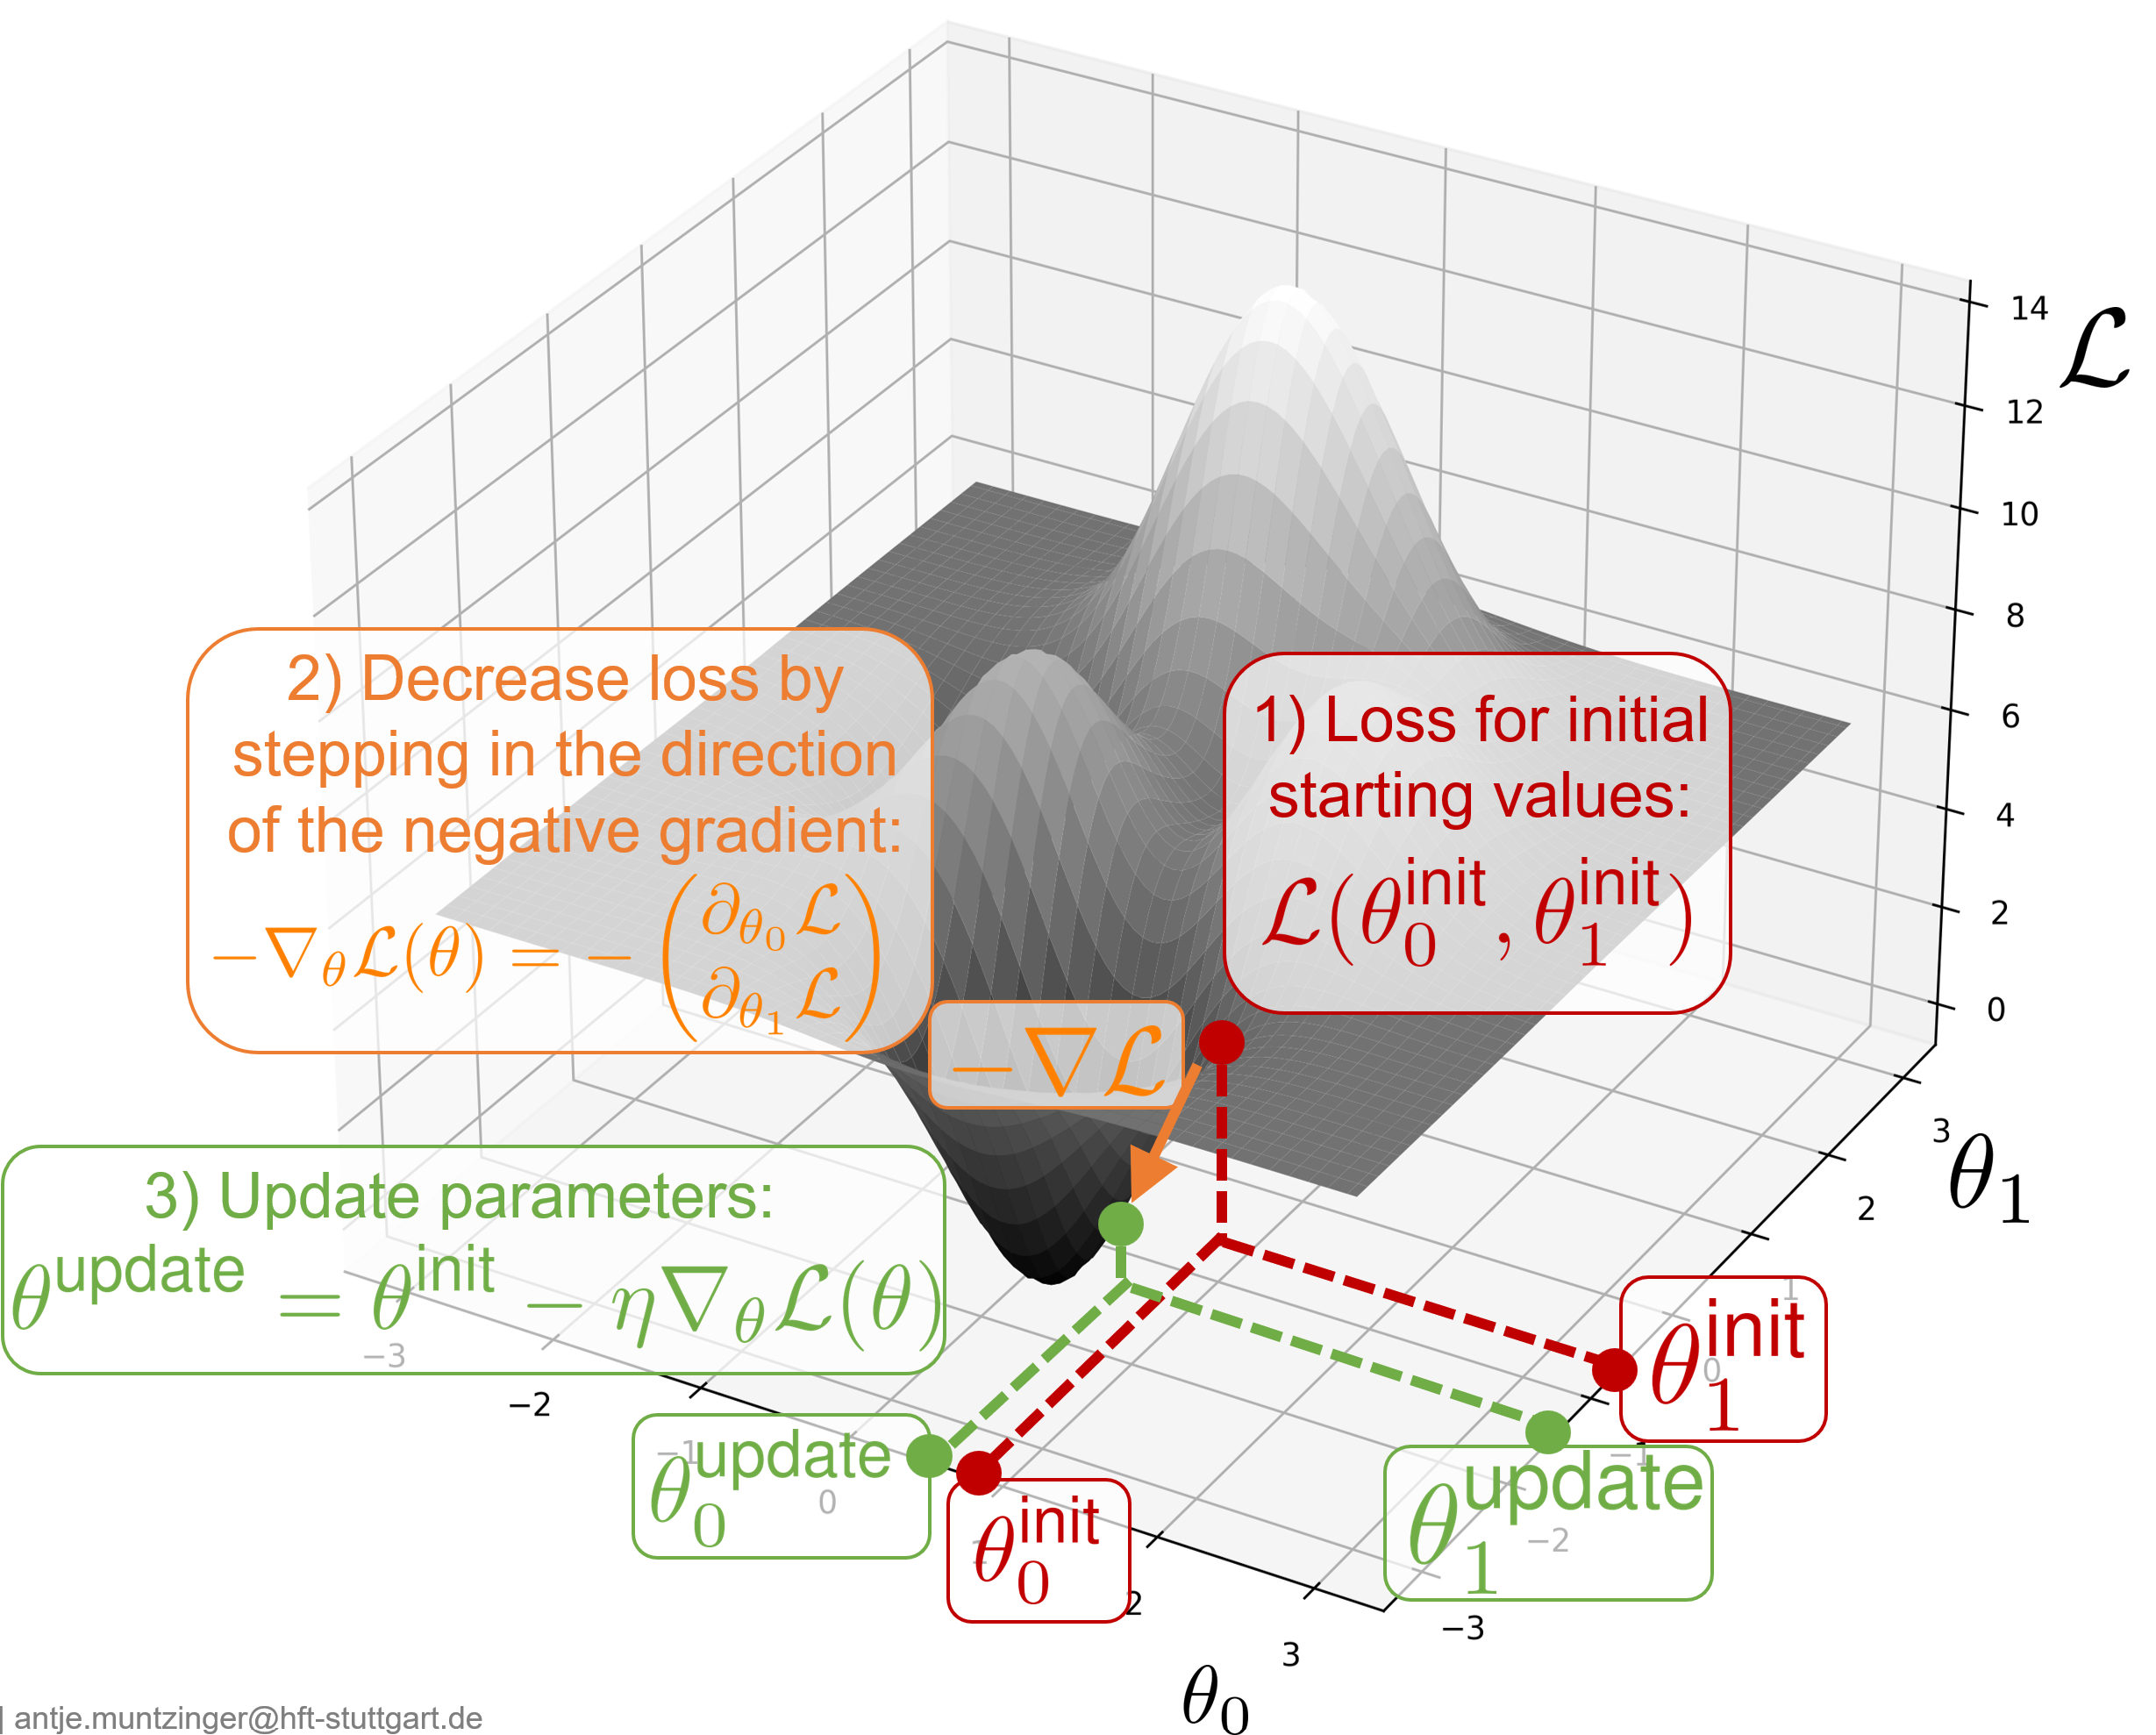

In [9]:
Image('gradient_descent.png', width=500)

To calculate the gradient, we need the partial derivatives with respect to our weights $\theta$ that we want to adopt. The first partial derivative for $\theta = (70, 1)^T$ is shown below:

$\frac{\partial}{\partial \theta_0} = \frac{2}{m} \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)})x_0^{(i)} \\[1em]
\hspace{5mm} = \frac{2}{3}[(-130)\cdot1 + (-60)\cdot1 + (-290)\cdot1] = -320$ 


In [10]:
#calculate first partial derivatives of MSE with respect to theta
partial0_MSE = 2/m * (((x_with_bias[0] @ theta - y[0]) * x_with_bias[0][0]) + ((x_with_bias[1] @ theta - y[1]) * x_with_bias[1][0]) + ((x_with_bias[2] @ theta - y[2]) * x_with_bias[2][0]))
print('partial0_MSE = ', partial0_MSE)

partial0_MSE =  [-320.]


And the second partial derivative for $\theta = (70, 1)^T$ is:

$\frac{\partial}{\partial \theta_1} = \frac{2}{m} \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)})x_1^{(i)} \\[1em]
\hspace{5mm} = \frac{2}{3}[(-130)\cdot100 + (-60)\cdot70 + (-290)\cdot140] = -38533$ 

In [11]:
# calculate second partial derivatives of MSE with respect to theta
partial1_MSE = 2/m * (((x_with_bias[0] @ theta - y[0]) * x_with_bias[0][1]) + ((x_with_bias[1] @ theta - y[1]) * x_with_bias[1][1]) + ((x_with_bias[2] @ theta - y[2]) * x_with_bias[2][1]))
print('partial1_MSE = ', partial1_MSE)  

partial1_MSE =  [-38533.33333333]


This gives the full gradient $\nabla_{\theta}MSE(\theta) = \left(\begin{matrix}-320 \\ -38533 \end{matrix} \right)$


In [12]:
# the gradient is just a vector containting these partial derivatives
gradient_MSE = np.array([partial0_MSE, partial1_MSE])
print('gradient_MSE = ', gradient_MSE)

gradient_MSE =  [[  -320.        ]
 [-38533.33333333]]


Now, we can finally calculate the gradient descent step and update the parameters:

$\theta^{(new)} = \theta^{(old)} - \alpha\cdot\nabla_{\theta}MSE(\theta) \\[1em]
\hspace{2em} = \left(\begin{matrix} 70 \\ 1 \end{matrix} \right) - 0.00005 \cdot \left(\begin{matrix} -320 \\ -38533 \end{matrix} \right)\\[1em]
\hspace{2em} = \left(\begin{matrix}70.016 \\ 2.9267\end{matrix} \right)$


In [13]:
theta = theta - alpha * gradient_MSE
print('theta = ', theta)

theta =  [[70.016     ]
 [ 2.92666667]]


Text(0.5, 1.0, 'Initial and Updated Lines')

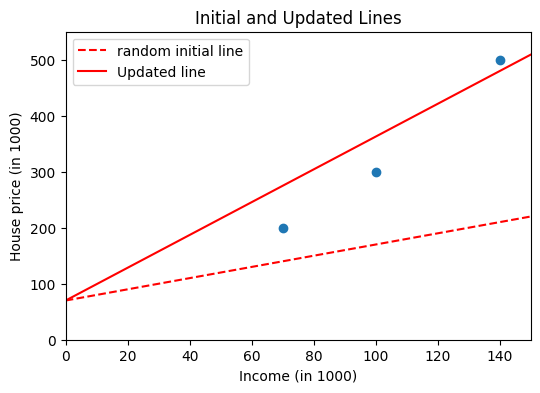

In [14]:
# plot initial and update line
plot_init_data()
plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', label = 'Updated line')
plt.legend()
plt.title("Initial and Updated Lines")

The update line looks a little bit better than the initial line!\
Now we repeat many more gradient descent steps to adapt the weights successively and improve our model:

i = 0 MSE = [3315.53998933] gradient_MSE = [[  78.20977778]
 [5783.30666667]] theta = [[70.01208951]
 [ 2.63750133]] 

i = 50000 MSE = [1358.34594428] gradient_MSE = [[18.35455317]
 [-0.164926  ]] theta = [[14.85378729]
 [ 3.17087184]] 

i = 100000 MSE = [756.57529703] gradient_MSE = [[12.83810027]
 [-0.11535756]] theta = [[-23.7269486 ]
 [  3.51754148]] 

i = 150000 MSE = [462.1704916] gradient_MSE = [[ 8.97961487]
 [-0.0806869 ]] theta = [[-50.71226126]
 [  3.76001971]] 

i = 200000 MSE = [318.13855875] gradient_MSE = [[ 6.28079557]
 [-0.05643648]] theta = [[-69.58715005]
 [  3.92962121]] 

i = 250000 MSE = [247.6736842] gradient_MSE = [[ 4.39310522]
 [-0.03947452]] theta = [[-82.7891993 ]
 [  4.04824906]] 

i = 300000 MSE = [213.20008903] gradient_MSE = [[ 3.07275937]
 [-0.02761047]] theta = [[-92.02337845]
 [  4.13122336]] 

i = 350000 MSE = [196.33454046] gradient_MSE = [[ 2.14924289]
 [-0.01931216]] theta = [[-98.4822291 ]
 [  4.18925977]] 

i = 400000 MSE = [188.08339267] gradie

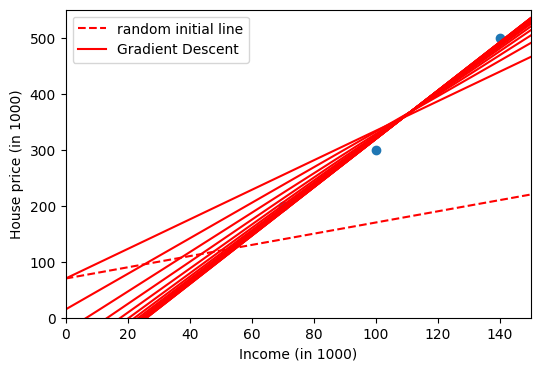

In [15]:
# let's make a loop to repeat these steps over and over
plot_init_data()
for i in range(n_iter):
    # calculate MSE with current parameters theta
    MSE = 1/m * ((x_with_bias[0] @ theta - y[0])**2 + (x_with_bias[1] @ theta - y[1])**2 + (x_with_bias[2] @ theta - y[2])**2)

    # calculate partial derivatives of MSE with respect to theta
    partial0_MSE = 2/m * (((x_with_bias[0] @ theta - y[0]) * x_with_bias[0][0]) + ((x_with_bias[1] @ theta - y[1]) * x_with_bias[1][0]) + ((x_with_bias[2] @ theta - y[2]) * x_with_bias[2][0]))
    partial1_MSE = 2/m * (((x_with_bias[0] @ theta - y[0]) * x_with_bias[0][1]) + ((x_with_bias[1] @ theta - y[1]) * x_with_bias[1][1]) + ((x_with_bias[2] @ theta - y[2]) * x_with_bias[2][1]))

    # the gradient is just a vector containting these partial derivatives
    gradient_MSE = np.array([partial0_MSE, partial1_MSE])

    # update theta
    theta = theta - alpha * gradient_MSE

    # print and plot some info and check for conversion
    if i % print_every == 0:
        print('i =', i, 'MSE =', MSE, 'gradient_MSE =', gradient_MSE, 'theta =', theta, '\n')
        plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', label = 'Gradient Descent' if i == 0 else "")

        if np.linalg.norm(gradient_MSE) < eps:
            print('Converged!!...')
            break

plt.legend()

We see that the line converges to a solution running nearly through the blue points, so we have found our optimal parameters!\

Alternatively, we can directly calculate the optimal solution $\hat{\theta} = (X^{T}X)^{-1}X^{T}y$ using the normal equation. This is computationally expensive, so we use gradient descent in practice, but for comparison here is the direct solution:

$\hat{\theta}=(X^{T}X)^{-1}X^{T}y = \left(\left(\begin{matrix} 1 & 1 & 1 \\ 100 & 70 & 140 \end{matrix}\right) \left(\begin{matrix} 1 & 100 \\ 1 & 70 \\ 1 & 140\end{matrix}\right) \right)^{-1} \left(\begin{matrix} 1 & 1 & 1 \\ 100 & 70 & 140 \end{matrix}\right) \left(\begin{matrix}300 \\ 200 \\ 500\end{matrix}\right)\\[1em]
= \left(\begin{matrix}3 & 310 \\ 310 & 34500 \end{matrix}\right)^{-1} \left(\begin{matrix}1000 \\ 114000 \end{matrix}\right) = \left(\begin{matrix}4.66216 & -0.04189 \\ -0.04189 & 0.0004\end{matrix}\right) \left(\begin{matrix}1000 \\ 114000 \end{matrix}\right) \approx \left(\begin{matrix} -113 \\ 4 \end{matrix} \right)$

This gives the optimal regression line y = 4x - 113.

theta_hat (direct solution) =  [[-113.51351351]
 [   4.32432432]]
theta (gradient descent) =  [[-112.9112194 ]
 [   4.31891237]]


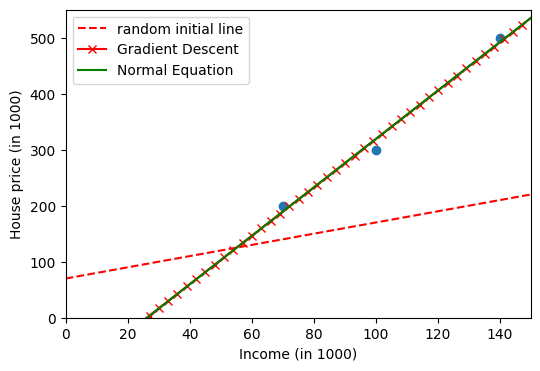

In [16]:
# Normal equation solution
theta_hat = np.linalg.inv(x_with_bias.T.dot(x_with_bias)).dot(x_with_bias.T).dot(y)
print('theta_hat (direct solution) = ', theta_hat)
print('theta (gradient descent) = ', theta)

# plot both lines
plot_init_data()
plt.plot(x_points, theta[0] + theta[1]*x_points, color='r', marker='x', markevery=10, label = 'Gradient Descent')
plt.plot(x_points, theta_hat[0] + theta_hat[1]*x_points, color='g', label = 'Normal Equation')
plt.legend()

